# Overview
This notebook applies some basic signal processing techniques to the bird sounds dataset for classification. 

## Extract
- Choose a cutoff minimum duration $s$. This will be the common duration for all the samples 
- Extract the signal and the sample rate for each sample
- For now just truncate to the middle $s$ seconds for each sample
- Resample to a common rate
- Save the signals and the labels to a dataset

## Transform
- Apply framing and windowing
- Apply the DTFT to produce the spectrogram
- Design a noise filter
- Normalize the spectrograms

## Train 
- Use a Tensorflow dataset to flow from the persisted dataset and apply the transformations
- Train a CNN model

# Imports

In [ ]:
import librosa
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import tensorflow as tf
import h5py
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers, models
import math
from scipy.io.wavfile import write
from scipy.signal import iirfilter, sosfilt

In [2]:
# Make sure GPU is available
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Exploratory Data Analysis
Here we will explore some basic properties of the dataset and choose a value for $s$ that makes sense based on the data.

In [19]:
metadata = pd.read_csv('/data/recordings.csv')

# Extract timestamps
metadata['length'] = metadata['length'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))

# Create dictionary of id to label
label_dict = dict(zip(metadata['id'], metadata['label']))

# lt = metadata[['gen', 'en', 'cnt']].head().to_latex()
# with open('metadata.tex', 'w') as f:
#     f.write(lt)

metadata.head()

,id,gen,sp,ssp,group,en,rec,cnt,loc,lat,...,bird-seen,animal-seen,playback-used,temp,regnr,auto,dvc,mic,smp,label
0,936105,Branta,bernicla,NaN,birds,Brant Goose,Arjun Dutta,United Kingdom,"Great Britain (near Wallington), Greater Lond...",51.3532,...,no,no,no,NaN,NaN,no,Tascam DR-05x,NaN,44100,goose
1,934302,Branta,bernicla,NaN,birds,Brant Goose,Mats Olsson,Sweden,"Dalgången 23, Karlshamn, Blekinge län",NaN,...,no,no,no,NaN,NaN,no,Wildlife Acoustics,NaN,24000,goose
2,906056,Branta,bernicla,NaN,birds,Brant Goose,Juha Saari,Finland,"Pihlajamäki, Helsinki, Uusimaa",60.2357,...,no,no,no,NaN,NaN,yes,NaN,Telinga PRO-X,44100,goose
3,898133,Branta,bernicla,NaN,birds,Brant Goose,Paul Kelly,Ireland,"Tacumshin Lake (East End), County Wexford",52.1963,...,no,no,no,NaN,NaN,yes,SM4,SM4,44100,goose
4,882013,Branta,bernicla,NaN,birds,Brant Goose,Jean COURTIN,France,"Arrondissement de Vannes (near Sérent), Morbi...",47.7981,...,yes,yes,no,NaN,NaN,yes,NaN,NaN,44100,goose


In [22]:
counts = metadata.groupby('gen')['length'].describe()[['mean', 'std', 'min', 'max']].to_latex()
with open('counts.tex', 'w') as f:
    f.write(counts)

In [37]:
metadata['length'].describe()

count    7006.000000
mean       42.353697
std        84.070134
min         0.000000
25%        10.000000
50%        21.000000
75%        45.000000
max      1800.000000
Name: length, dtype: float64

# Extract
Here we will:
- Load the data using `librosa`
- Truncate to extract the middle $s$ seconds
- Resample to a common sample rate
- Save the signals and labels to a file

In [9]:
def extract_middle(signal, fs, duration_seconds=10):
    duration_samples = duration_seconds * fs
    signal_length = len(signal)
    start = (signal_length - duration_samples) // 2
    end = start + duration_samples
    return signal[start:end]

def load_batch(batch, duration_seconds=10, target_fs=16000):
    signals = []
    labels = []
    ids = []
    for i, file in enumerate(batch):
        # Check that file exists
        if not os.path.exists(f'/data/recordings/{file}'):
            print(f'Skipping {file} due to missing file')
            continue
        signal, fs = librosa.load(f'/data/recordings/{file}', sr=None)
        signal = extract_middle(signal, fs, duration_seconds)
        if len(signal) != duration_seconds * fs:
            print(f'Skipping {file} due to incorrect duration')
            continue
        signal = librosa.resample(signal, orig_sr=fs, target_sr=target_fs)
        signals.append(signal)
        file_name = file.split('_')
        labels.append(file_name[0])
        ids.append(int(file_name[1].split('.')[0]))
    return np.array(signals), np.array(ids), np.array(labels)

def save_batch(batch, save_path, dataset_name='signals'):
    with h5py.File(save_path, 'a') as f:
        if dataset_name in f:
            dataset = f[dataset_name]
            dataset.resize(dataset.shape[0] + batch.shape[0], axis=0)
            dataset[-batch.shape[0]:] = batch
        else:
            maxshape = (None,) + batch.shape[1:]
            f.create_dataset(dataset_name, data=batch, maxshape=maxshape, chunks=True)

def get_batches(file_list, batch_size):
    for i in range(0, len(file_list), batch_size):
        yield file_list[i:i + batch_size]

def extract_signals(file_list, save_path, ohe, duration_seconds=10, batch_size=32, target_fs=16000):
    for i, batch_files in enumerate(get_batches(file_list, batch_size)):
        signals, ids, labels = load_batch(batch_files, duration_seconds, target_fs)
        labels = ohe.transform(labels.reshape(-1, 1)).toarray()
        save_batch(signals, save_path, f'signals_{duration_seconds}s_{target_fs}hz')
        save_batch(labels, save_path, 'labels')
        save_batch(ids, save_path, 'ids')
        print(f'Saved {len(batch_files)} signals for batch {i}')

In [10]:
signals, ids, labels = load_batch(['hawk_531031.mp3'], duration_seconds=10, target_fs=16000)

In [ ]:
ohe = OneHotEncoder().fit(np.array(['hawk', 'heron', 'goose']).reshape(-1, 1))

In [17]:
# Load a single signal from the dataset
def load_dataset(file_path, indices, duration_seconds=10, target_fs=16000):
    with h5py.File(file_path, 'r') as f:
        signals = f[f'signals_{duration_seconds}s_{target_fs}hz'][indices]
        labels = f['labels'][indices]
        ids = f['ids'][indices]
    return signals, labels, ids

In [18]:
signals, labels, ids = load_dataset('/data/bird_sounds.h5', slice(0, 20))

In [19]:
# Listen to the first signal
write('/data/test.wav', 16000, signals[0, :])

## Transform
Here we will build a TensorFlow dataset that reads from the saved file in batches and applies the following transformations:
- Framing
- Windowing (using a Hamming function)
- FFT (real-valued) to produce the spectrogram
- Take the log magnitude of the spectrum
- Normalize

In [38]:
def build_signal_dataset(dataset, batch_size, frame_size = 1024, step_size = 512):
    window = tf.signal.hamming_window(frame_size)
    
    # Framing
    dataset = dataset.map(
        lambda signals, labels: (tf.signal.frame(signals, frame_size, step_size), labels),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Windowing
    dataset = dataset.map(
        lambda signals, labels: (signals * window, labels),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Real-valued Fourier Transform
    dataset = dataset.map(
        lambda signals, labels: (tf.abs(tf.signal.rfft(signals)), labels),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Centering
    dataset = dataset.map(
        lambda signals, labels: (signals - tf.reduce_mean(signals, axis=(1, 2), keepdims=True), labels),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Log-magnitude
    dataset = dataset.map(
        lambda signals, labels: (tf.math.log(signals + 1e-6), labels),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Normalization
    dataset = dataset.map(
        lambda signals, labels: (tf.math.divide(signals, tf.reduce_max(signals)), labels),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [39]:
def compute_input_size(sample_rate, duration_seconds, frame_size, step_size):
    signal_length = sample_rate * duration_seconds
    
    # Compute the number of frames
    num_frames = math.floor((signal_length - frame_size) / step_size) + 1
    
    # Compute the number of frequency bins
    frequency_bins = frame_size // 2 + 1
    
    return num_frames, frequency_bins

## Testing Transformation Pipeline

In [10]:
sample_rate = 16000 # Resample to 16kHz
frame_size = int(0.05 * sample_rate)
step_size = frame_size // 4 # 25% overlap 
batch_size = 32

In [2]:
with h5py.File('/data/bird_sounds.h5', 'r') as f:
    all_labels = f['labels'][:]

num_geese = 1453
num_hawks = 2042
num_herons = 1658

sum(all_labels)

array([1453., 2042., 1658.])

In [3]:
num_geese+num_hawks+num_herons

5153

In [24]:
5152/7006

0.7353696831287468

#### Save all recordings to WAV

In [ ]:
with h5py.File('/data/bird_sounds.h5', 'r') as f:
    all_signals = f['signals_10s_16000hz'][:]
    all_labels = f['labels'][:]
    
for i, (signal, label) in enumerate(zip(all_signals, np.argmax(all_labels, axis=1))):
    write(f'/data/short-recordings/{i}_{label}.wav', 16000, signal)

In [5]:
def get_signals(indices):
    with h5py.File('/data/bird_sounds.h5', 'r') as f:
        signals = f['signals_10s_16000hz'][indices]
        labels = f['labels'][indices]
    return signals, labels

In [5]:
chosen_goose, _ = get_signals(range(3, 4))
chosen_hawk, _ = get_signals(range(num_geese + 2, num_geese + 3))
chosen_heron, _ = get_signals(range(num_geese + num_hawks + 7, num_geese + num_hawks + 8))

In [297]:
write('/data/sounds/goose.wav', 16000, chosen_goose[0])
write('/data/sounds/hawk.wav', 16000, chosen_hawk[0])
write('/data/sounds/heron.wav', 16000, chosen_heron[0])

In [7]:
num_samples = 32

In [8]:
goose_signals, _ = get_signals(range(num_samples))
hawk_signals, _ = get_signals(range(num_geese, num_geese + num_samples))
heron_signals, _ = get_signals(range(num_geese + num_hawks, num_geese+num_hawks+num_samples))

In [11]:
def process_data(signals, frame_size, step_size):
    window = tf.signal.hamming_window(frame_size)
    frames = tf.signal.frame(signals, frame_size, step_size)
    windowed = frames * window
    ft = tf.abs(tf.signal.rfft(windowed))
    mean_value = tf.reduce_mean(ft, axis=(1, 2), keepdims=True)
    ft = ft - mean_value
    ft = tf.math.log(tf.abs(ft) + 1e-6)
    ft = tf.math.divide(ft, tf.reduce_max(ft))
    return ft

goose_spectrograms = process_data(goose_signals, frame_size, step_size)
hawk_spectrograms = process_data(hawk_signals, frame_size, step_size)
heron_spectrograms = process_data(heron_signals, frame_size, step_size)

I0000 00:00:1732590104.122640   51181 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


#### Cherry Picked Observations

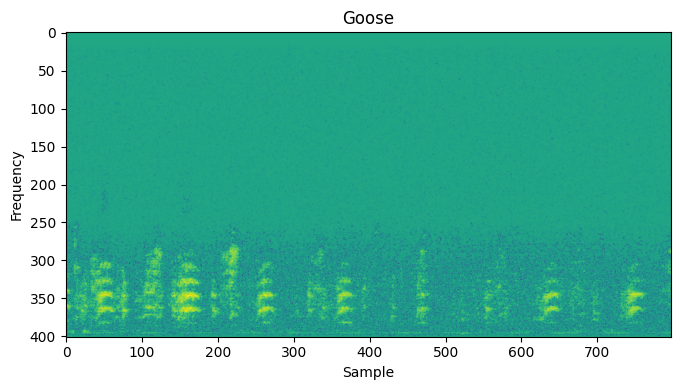

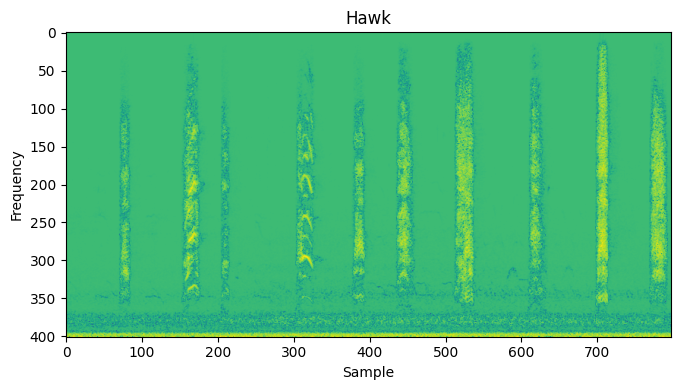

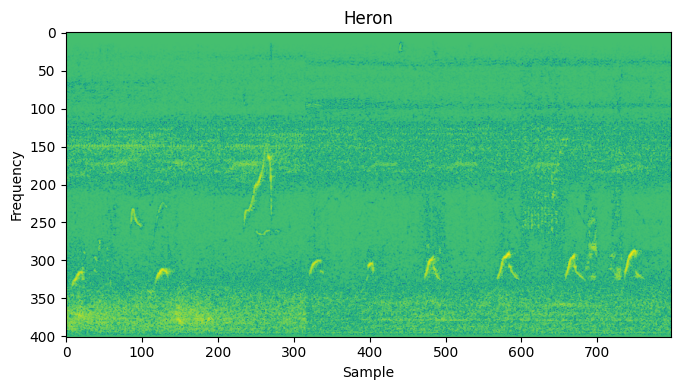

In [12]:
def plot_spectrogram(spectrogram, title):
    plt.figure(figsize=(10, 4))
    plt.imshow(np.flip(tf.transpose(spectrogram), axis=0))
    plt.title(title)
    plt.xlabel('Sample')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig(f'/data/spectrograms/example_{title}.png')

plot_spectrogram(goose_spectrograms[24, :, :], 'Goose')
plot_spectrogram(hawk_spectrograms[19, :, :], 'Hawk')
plot_spectrogram(heron_spectrograms[27, :, :], 'Heron')

#### Lots of Samples

In [ ]:
# Create three figures, each 4 rows and 8 columns
# Plot the spectrograms of the first 32 signals for each bird
def plot_spectrograms(spectrograms, title):
    fig, axs = plt.subplots(10, 3, figsize=(16, 24))
    fig.suptitle(title, fontsize=20)
    for i, ax in enumerate(axs.flat):
        ax.imshow(tf.transpose(spectrograms[i, :, :]))
        ax.set_title(f'Signal {i}')
        
        # Turn of axis labels
        ax.axis('off')
    plt.savefig(f'/data/spectrograms/{title}.png')

plot_spectrograms(goose_spectrograms, 'Goose')
plot_spectrograms(hawk_spectrograms, 'Hawk')
plot_spectrograms(heron_spectrograms, 'Heron')

# Train

In [22]:
def build_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

    return model